# Notebook E — Create and save paired direct solves (ω′, ω=2ω′) on ≥501×501 grids

This notebook creates a training dataset for **frequency transfer** with an **identity baseline**:

- Low frequency: **ω′**
- High frequency: **ω = 2·ω′**
- For each sample, we generate a randomized **multi-source RHS** (1–5 delta-like bumps),
  solve the Helmholtz equation at both frequencies **on the same extended grid**, and save:
  - `c(x,y)` (medium)
  - `f(x,y)` (RHS)
  - `u_ω′(x,y)` (low-frequency solution)
  - `u_ω(x,y)` (high-frequency solution)

### Why “same grid” per sample?
The identity transfer operator means:
\[
T_{id}(u_{\omega'}) = u_{\omega'}
\]
That only makes sense if `u_ω′` and `u_ω` live on the **same grid**.  
So for each sample we build the grid **from ω (high)**, then solve both ω′ and ω on that grid.

### What you’ll visualize
For a few samples we plot:
- `|f|`
- `|u_ω′|`, `|u_ω|`
- correction over identity: `|Δu| = |u_ω - u_ω′|`
- identity residual at high frequency: `r_id = f - A(ω) u_ω′`

---

## Anything missing in `src/`?
Nothing is strictly missing.  
(Optionally, if you prefer: a small `io.save_npz_sample(...)` helper could live in `src/` instead of the notebook, but it’s not required.)

In [1]:
# ---- Imports: use functions defined in src/ ----
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from core.config import HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.rhs import RHSConfig, assemble_rhs
from core.resolution import grid_from_ppw_with_pml_extension
from core.grid import embed_in_extended, extract_physical

from operators.solve import solve_helmholtz, compute_residual
from operators.assemble import assemble_helmholtz_matrix

np.set_printoptions(precision=3, suppress=True)

In [3]:
# =========================
# Configuration (edit here)
# =========================

OUT_ROOT = Path("data/paired_omega2_dataset")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Physical domain size
LX, LY = 1.0, 1.0

# Frequencies (requested: lowest ω′ = 32, ω = 2 ω′)
OMEGA_LOW_LIST = [32, 40, 48]   # ω′ values
RATIO = 2.0

# Grid rule (physical grid must be >= 501×501)
PPW = 10.0
N_MIN_PHYS = 501
NPML = 40

# PML params for the operator
PML_POWER = 3.0
ETA = 7.0     # strength = ETA * omega

# RHS: random 1–5 delta-like sources (implemented as narrow Gaussians in index-space)
RHS_CFG = RHSConfig(
    mode="random_gaussians",
    k_min=1,
    k_max=5,
    amp_dist="uniform",
    amp_scale=1.0,
    complex_amps=True,
    width_min_cells=1.5,
    width_max_cells=2.5,
    avoid_pml=True,
    pml_margin_cells=4,
    normalize="l2",
    target_norm=1.0,
    base_seed=0,
    include_omega_in_seed=False,  # ensures RHS is identical for the (ω′, ω) pair
    zero_boundary=True,
)

# Dataset sizes (start small; scale later)
N_TRAIN = 30
N_VAL   = 3
N_TEST  = 3

# Medium case(s)
CASES = make_default_cases()
CASE_NAME = "const"

# Reproducibility (for selecting omega per sample)
np.random.seed(0)

## 1) One paired solve (ω′, ω) on a shared extended grid

We do this **without adding new solver logic**:

- `grid_from_ppw_with_pml_extension(...)` builds `grid_phys`, `grid_ext`, and `core_slices`.
- `build_medium(...)` constructs `c_phys` on the physical grid.
- `assemble_rhs(...)` constructs `f_phys` (paired across ω′/ω by `include_omega_in_seed=False`).
- `embed_in_extended(...)` embeds `c_phys` and `f_phys` into the extended arrays.
- `solve_helmholtz(...)` solves twice on the extended grid:
  - once with ω′
  - once with ω
- `assemble_helmholtz_matrix(...)` + `compute_residual(...)` gives the identity residual
  \(r_{id} = f - A(\omega) u_{\omega'}\).

To keep the notebook clean and readable, we wrap this in **one** small helper.

In [4]:
def paired_solve_shared_grid(*, omega_low: float, sample_id: int, case_name: str = CASE_NAME):
    omega_low = float(omega_low)
    omega_high = float(RATIO) * omega_low

    case = CASES[case_name]

    # Build extended grid using omega_high so ω′ and ω share the same grid
    ext = grid_from_ppw_with_pml_extension(
        omega=omega_high,
        ppw=PPW,
        lx=LX,
        ly=LY,
        npml=NPML,
        c_min=1.0,
        n_min_phys=N_MIN_PHYS,
        make_odd_phys=True,
        x_min_phys=0.0,
        y_min_phys=0.0,
    )
    gphys, gext = ext.grid_phys, ext.grid_ext
    core = ext.core_slices

    # Medium on physical grid
    Xp, Yp = gphys.mesh()
    cfg_phys_low = HelmholtzConfig(omega=omega_low, grid=gphys, pml=None)
    c_phys = build_medium(cfg_phys_low, case, Xp, Yp).astype(float)

    # RHS on physical grid (assemble_rhs returns a flattened vector)
    f_vec, rhs_meta = assemble_rhs(cfg_phys_low, case, Xp, Yp, rhs_cfg=RHS_CFG, sample_id=int(sample_id), return_meta=True)
    f_phys = np.asarray(f_vec, dtype=np.complex128).reshape(gphys.nx, gphys.ny)

    # Embed to extended
    c_ref = float(np.min(c_phys))
    c_ext = embed_in_extended(c_phys, (gext.nx, gext.ny), core, fill_value=c_ref, dtype=float)
    f_ext_2d = embed_in_extended(f_phys, (gext.nx, gext.ny), core, fill_value=0.0, dtype=np.complex128)
    f_ext = np.asarray(f_ext_2d).reshape(-1)

    # Extended-domain configs (PML enabled)
    def mk_cfg(omega: float) -> HelmholtzConfig:
        return HelmholtzConfig(
            omega=float(omega),
            grid=gext,
            pml=PMLConfig(thickness=int(NPML), strength=float(ETA * omega), power=float(PML_POWER)),
        )

    cfg_low  = mk_cfg(omega_low)
    cfg_high = mk_cfg(omega_high)

    sol_low  = solve_helmholtz(cfg_low,  c=c_ext, f=f_ext, return_matrix=False, return_residual=True)
    sol_high = solve_helmholtz(cfg_high, c=c_ext, f=f_ext, return_matrix=False, return_residual=True)

    U_low_ext  = sol_low["U"]
    U_high_ext = sol_high["U"]

    U_low  = extract_physical(U_low_ext, core)
    U_high = extract_physical(U_high_ext, core)

    # Identity baseline: u0_high := u_low (in extended vector form)
    u_low_ext_vec = sol_low["u"]

    # Identity residual at high frequency on extended domain, then slice to physical
    A_high = assemble_helmholtz_matrix(cfg_high, c_ext)
    r_id_ext = compute_residual(A_high, u_low_ext_vec, f_ext).reshape(gext.nx, gext.ny)
    r_id = extract_physical(r_id_ext, core)

    dU = U_high - U_low

    return {
        "case": case_name,
        "sample_id": int(sample_id),
        "omega_low": omega_low,
        "omega_high": omega_high,
        "grid_phys": {"nx": int(gphys.nx), "ny": int(gphys.ny), "lx": float(gphys.lx), "ly": float(gphys.ly), "hx": float(gphys.hx), "hy": float(gphys.hy)},
        "grid_ext": {"nx": int(gext.nx), "ny": int(gext.ny), "lx": float(gext.lx), "ly": float(gext.ly), "hx": float(gext.hx), "hy": float(gext.hy)},
        "pml": {"npml": int(NPML), "eta": float(ETA), "power": float(PML_POWER)},
        "rhs_meta": rhs_meta,
        "c": c_phys,
        "f": f_phys,
        "u_low": U_low,
        "u_high": U_high,
        "du": dU,
        "r_id": r_id,
        "norms_low": sol_low.get("norms", {}),
        "norms_high": sol_high.get("norms", {}),
    }

## 2) Visualization (fields, residuals, correction)

These plots are meant to make your intuition track:
- low vs high oscillations
- what “identity transfer” misses (`Δu`)
- where the high-frequency equation is violated by the identity guess (`r_id`)

In [5]:
def plot_overview(sample, *, show_real=False):
    f = sample["f"]
    uL = sample["u_low"]
    uH = sample["u_high"]
    du = sample["du"]
    r  = sample["r_id"]

    fig, ax = plt.subplots(1, 5, figsize=(18, 3.6))
    im0 = ax[0].imshow(np.abs(f), origin="lower");  ax[0].set_title("|f|")
    im1 = ax[1].imshow(np.abs(uL), origin="lower"); ax[1].set_title("|u_ω′|")
    im2 = ax[2].imshow(np.abs(uH), origin="lower"); ax[2].set_title("|u_ω|")
    im3 = ax[3].imshow(np.abs(du), origin="lower"); ax[3].set_title("|Δu|=|u_ω-u_ω′|")
    im4 = ax[4].imshow(np.abs(r), origin="lower");  ax[4].set_title("|r_id|=|f-A(ω)u_ω′|")
    for a in ax:
        a.set_xticks([]); a.set_yticks([])
    fig.colorbar(im4, ax=ax, fraction=0.02, pad=0.02)
    plt.tight_layout()
    plt.show()

    if show_real:
        fig, ax = plt.subplots(1, 4, figsize=(16, 3.6))
        im0 = ax[0].imshow(np.real(uL), origin="lower"); ax[0].set_title("Re(u_ω′)")
        im1 = ax[1].imshow(np.real(uH), origin="lower"); ax[1].set_title("Re(u_ω)")
        im2 = ax[2].imshow(np.real(du), origin="lower"); ax[2].set_title("Re(Δu)")
        im3 = ax[3].imshow(np.real(r),  origin="lower"); ax[3].set_title("Re(r_id)")
        for a in ax:
            a.set_xticks([]); a.set_yticks([])
        fig.colorbar(im3, ax=ax, fraction=0.02, pad=0.02)
        plt.tight_layout()
        plt.show()

## 3) Smoke test (one sample)

This should run end-to-end and show the plots.

grid_phys: {'nx': 501, 'ny': 501, 'lx': 1.0, 'ly': 1.0, 'hx': 0.002, 'hy': 0.002}
norms_low : {'||r||2': 2.755096813014509e-13, '||f||2': 0.9999999999999999, '||r||2/||f||2': 2.7550968130145097e-13, '||u||2': 0.001507356134824903, '||r||inf': 4.390535536265132e-14}
norms_high: {'||r||2': 5.355685213154067e-13, '||f||2': 0.9999999999999999, '||r||2/||f||2': 5.355685213154068e-13, '||u||2': 0.0007981420742671171, '||r||inf': 4.63310967519253e-13}


C:\Users\31624\AppData\Local\Temp\ipykernel_10444\2231879032.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


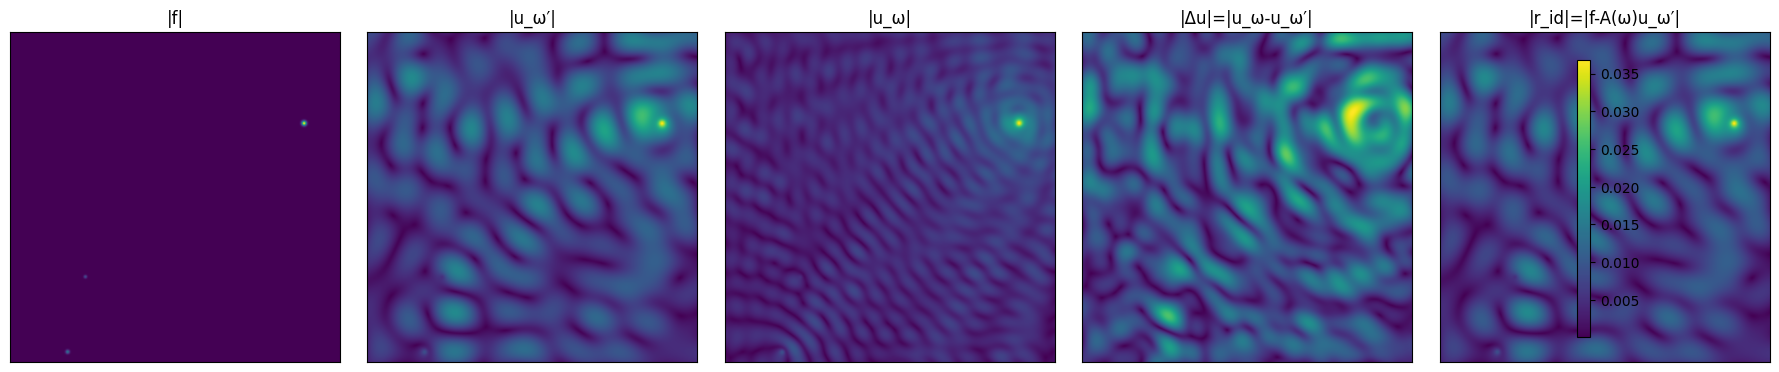

In [7]:
s0 = paired_solve_shared_grid(omega_low=OMEGA_LOW_LIST[0], sample_id=0)

print("grid_phys:", s0["grid_phys"])
print("norms_low :", s0["norms_low"])
print("norms_high:", s0["norms_high"])

plot_overview(s0, show_real=False)

## 4) Saving samples (`.npz` per sample + `index.csv`)

We save *physical-domain* arrays only (easy for ML), with complex fields split into re/im channels:
- `c` float32 (nx,ny)
- `f_re`, `f_im`
- `u_low_re`, `u_low_im`
- `u_high_re`, `u_high_im`
- `du_re`, `du_im`
- `r_id_re`, `r_id_im`
- `meta_json`

This is intentionally transparent and easy to inspect.

In [6]:
import pandas as pd

def save_npz(folder: Path, sample: dict, fname: str):
    folder.mkdir(parents=True, exist_ok=True)

    c = sample["c"].astype(np.float32)
    f = sample["f"].astype(np.complex64)
    uL = sample["u_low"].astype(np.complex64)
    uH = sample["u_high"].astype(np.complex64)
    du = sample["du"].astype(np.complex64)
    r  = sample["r_id"].astype(np.complex64)

    meta = {
        "case": sample["case"],
        "sample_id": sample["sample_id"],
        "omega_low": sample["omega_low"],
        "omega_high": sample["omega_high"],
        "grid_phys": sample["grid_phys"],
        "grid_ext": sample["grid_ext"],
        "pml": sample["pml"],
        "rhs_meta": sample.get("rhs_meta", {}),
        "norms_low": sample.get("norms_low", {}),
        "norms_high": sample.get("norms_high", {}),
        "created_utc": datetime.datetime.utcnow().isoformat() + "Z",
    }

    np.savez_compressed(
        folder / fname,
        c=c,
        f_re=np.real(f).astype(np.float32),
        f_im=np.imag(f).astype(np.float32),
        u_low_re=np.real(uL).astype(np.float32),
        u_low_im=np.imag(uL).astype(np.float32),
        u_high_re=np.real(uH).astype(np.float32),
        u_high_im=np.imag(uH).astype(np.float32),
        du_re=np.real(du).astype(np.float32),
        du_im=np.imag(du).astype(np.float32),
        r_id_re=np.real(r).astype(np.float32),
        r_id_im=np.imag(r).astype(np.float32),
        meta_json=json.dumps(meta),
    )

## 5) Generate train/val/test splits

We keep splits disjoint by `sample_id` ranges.  
We also randomly choose ω′ from `OMEGA_LOW_LIST` for each sample.

In [12]:
%pip install pandas tqdm


  Using cached pandas-3.0.0-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-3.0.0-cp312-cp312-win_amd64.whl (9.7 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)

   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ------------- -------------------------- 1/3 [tqdm]
   ------------- -------------------------- 1/3 [tqdm]
   ------------- -------------------------- 1/3 [tqdm]
   ------------- -------------------------- 1/3 [tqdm]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   ---------

In [5]:
N_TRAIN = 50
N_VAL   = 5
N_TEST  = 5


In [8]:
import datetime


In [9]:
from tqdm import tqdm

def generate_split(split: str, n: int, start_id: int):
    split_dir = OUT_ROOT / split
    rows = []
    sid = int(start_id)

    for _ in tqdm(range(n), desc=f"Generating {split}"):
        omega_low = float(np.random.choice(OMEGA_LOW_LIST))
        sample = paired_solve_shared_grid(omega_low=omega_low, sample_id=sid, case_name=CASE_NAME)

        fname = f"{CASE_NAME}_sid{sid:06d}_w{int(sample['omega_low'])}_w{int(sample['omega_high'])}.npz"
        save_npz(split_dir, sample, fname)

        rows.append({
            "split": split,
            "file": str((split_dir / fname).as_posix()),
            "case": CASE_NAME,
            "sample_id": sid,
            "omega_low": sample["omega_low"],
            "omega_high": sample["omega_high"],
            "nx": sample["grid_phys"]["nx"],
            "ny": sample["grid_phys"]["ny"],
        })
        sid += 1

    return rows, sid

train_rows, next_id = generate_split("train", N_TRAIN, 0)
val_rows, next_id   = generate_split("val",   N_VAL,   next_id)
test_rows, next_id  = generate_split("test",  N_TEST,  next_id)

index = pd.DataFrame(train_rows + val_rows + test_rows)
index_path = OUT_ROOT / "index.csv"
index.to_csv(index_path, index=False)

print("Saved:", index_path)
print(index.head())

Generating train:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\31624\AppData\Local\Temp\ipykernel_21688\3650254496.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.datetime.utcnow().isoformat() + "Z",
Generating train:   3%|▎         | 1/30 [02:20<1:07:47, 140.27s/it]C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\rhs.py:106: RuntimeWarning: overflow encountered in scalar multiply
  seed ^= np.uint64(sample_id + 1) * np.uint64(0x9E3779B97F4A7C15)
Generating test: 100%|██████████| 3/3 [07:22<00:00, 147.43s/it]

Saved: data\paired_omega2_dataset\index.csv
   split                                               file   case  sample_id  \
0  train  data/paired_omega2_dataset/train/const_sid0000...  const          0   
1  train  data/paired_omega2_dataset/train/const_sid0000...  const          1   
2  train  data/paired_omega2_dataset/train/const_sid0000...  const          2   
3  train  data/paired_omega2_dataset/train/const_sid0000...  const          3   
4  train  data/paired_omega2_dataset/train/const_sid0000...  const          4   

   omega_low  omega_high   nx   ny  
0       40.0        80.0  501  501  
1       32.0        64.0  501  501  
2       40.0        80.0  501  501  
3       40.0        80.0  501  501  
4       48.0        96.0  501  501  


## 6) Quick QC: load a few saved samples + visualize

This confirms:
- saved shapes match what you expect
- residual/correction fields look reasonable

Loaded: const_sid000003_w40_w80.npz sid: 3 ω′: 40.0 ω: 80.0


C:\Users\31624\AppData\Local\Temp\ipykernel_21688\2231879032.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


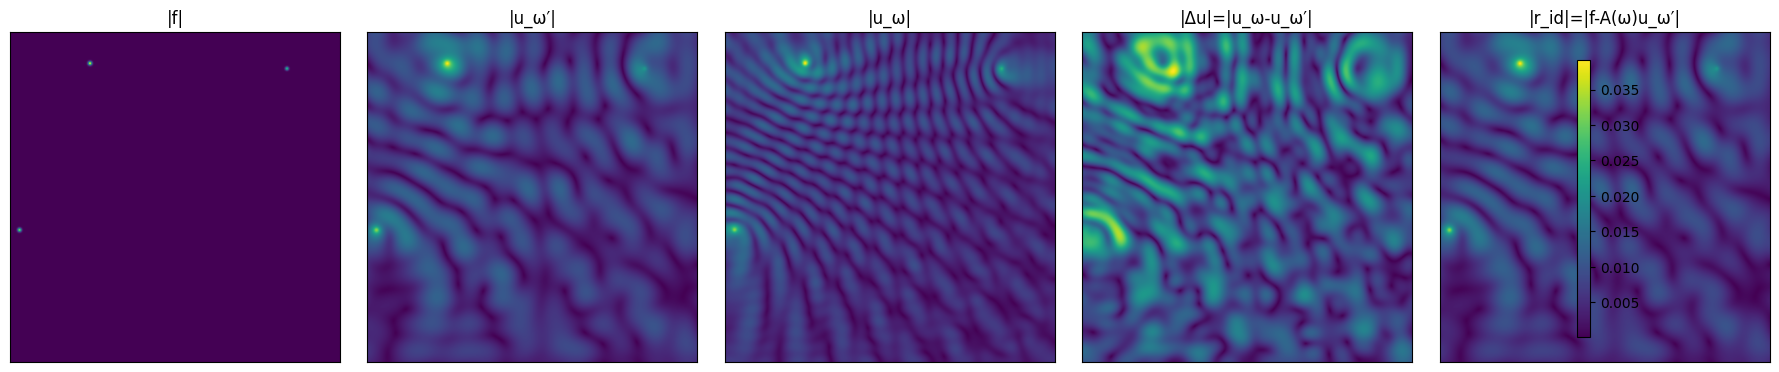

Loaded: const_sid000009_w32_w64.npz sid: 9 ω′: 32.0 ω: 64.0


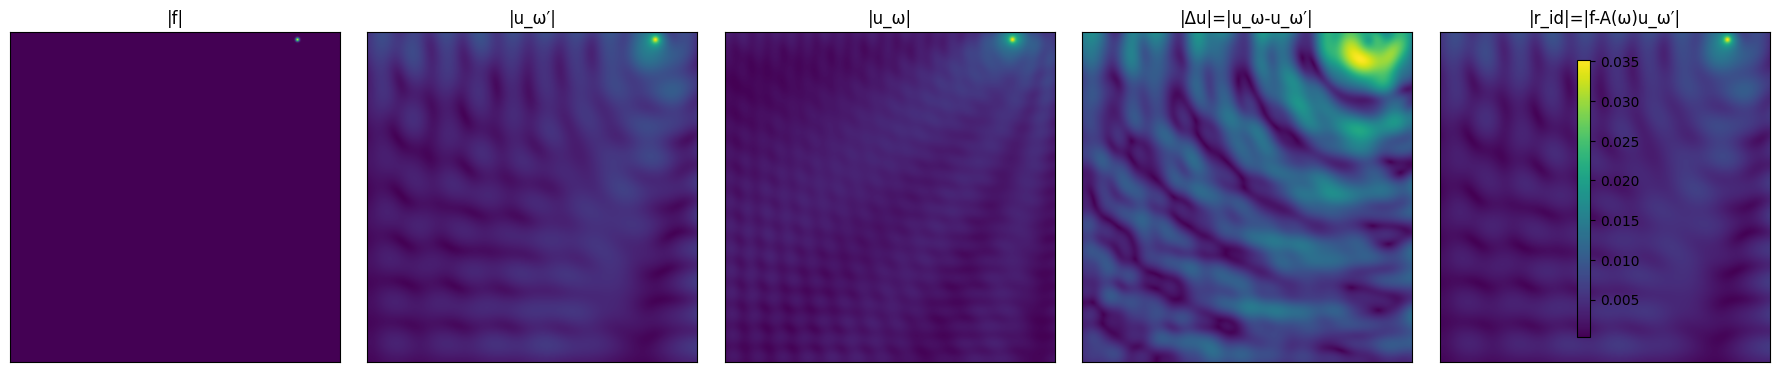

Loaded: const_sid000000_w64_w128.npz sid: 0 ω′: 64.0 ω: 128.0


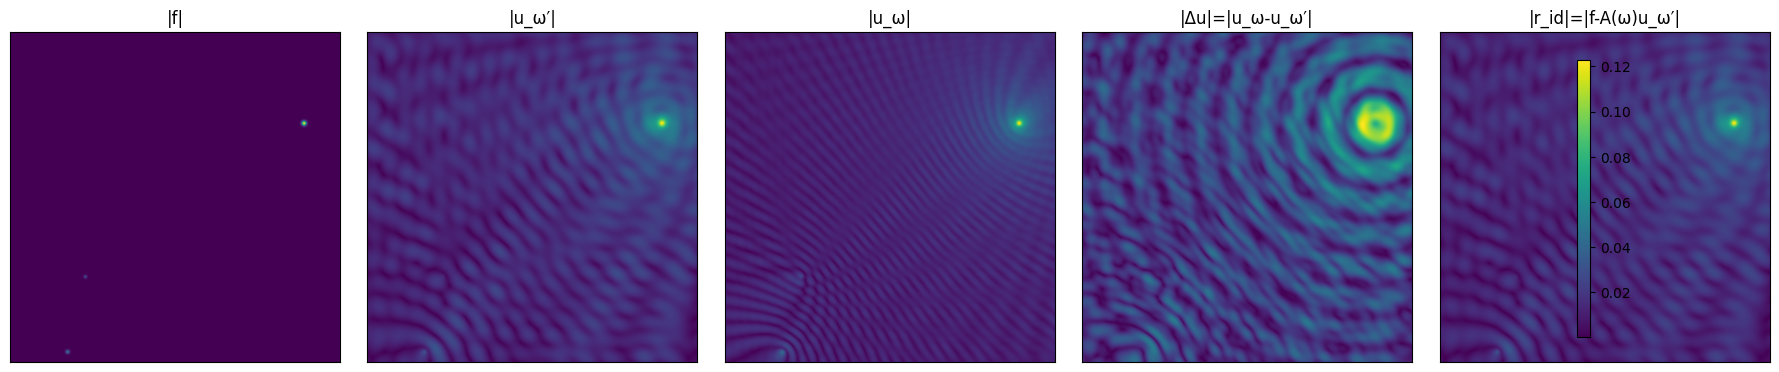

In [10]:
import random

def load_npz(path: Path):
    d = np.load(path, allow_pickle=True)
    meta = json.loads(str(d["meta_json"]))
    out = {
        "c": d["c"],
        "f": d["f_re"] + 1j*d["f_im"],
        "u_low": d["u_low_re"] + 1j*d["u_low_im"],
        "u_high": d["u_high_re"] + 1j*d["u_high_im"],
        "du": d["du_re"] + 1j*d["du_im"],
        "r_id": d["r_id_re"] + 1j*d["r_id_im"],
        "meta": meta,
    }
    return out

train_files = list((OUT_ROOT / "train").glob("*.npz"))
for p in random.sample(train_files, k=min(3, len(train_files))):
    s = load_npz(p)
    print("Loaded:", p.name, "sid:", s["meta"]["sample_id"], "ω′:", s["meta"]["omega_low"], "ω:", s["meta"]["omega_high"])
    plot_overview({
        "f": s["f"],
        "u_low": s["u_low"],
        "u_high": s["u_high"],
        "du": s["du"],
        "r_id": s["r_id"],
    })